# Test using printed letters

Example taken from https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial

In [26]:
#Import required libraries

#Some of thye internal functions in tensorflow_backend has been replaced with updated version so they show some warnings
#the previous functions still work so we can just ignore the warnings 

import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

In [27]:
#This function will extract images packed in gzip files
#extract_data returns a vector of "num_images" of 28x28 pixels
#extract_labels returns a column vector with numbered classes

def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data
    
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [28]:
#Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [29]:
#Load 60k images for training and 10k for test

train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [30]:
#Labels are only needed for plotting but not for training the network

train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [31]:
#Verify the shapes of training and test sets

print("Training set (images) shape: {shape}".format(shape=train_data.shape))
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [32]:
#Reshape data to 4-dimensional vectors ===> (num imgs, rows, cols, chans)
#chans means the colors data series the images contain, 3 for RGB, 1 for grayscale

train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [33]:
#Normalize pixel values

train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [34]:
#Verify the maximun value is now 1

np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [35]:
#Separate the training data, use 20% of training samples to validate the model
#This reduces the change of overfitting because we perform validation with samples
#that haven't seen before while training the network

from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [36]:
#Add some gaussian noise (mean 0, deviation 1) to the input images
#Noise factor is our hyperparameter, set it to 0.5 as default

#Clipping data is a good practice when adding noise. It can generate negative numbers of values greater than 1
#clip would set them to 0 or 1 respectively

noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

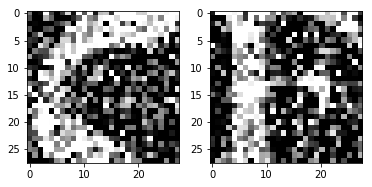

In [37]:
#Verify the noise was applied properly

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [38]:
#Define hyperparameters for training
#Epoch defines the number times that the learning algorithm will work through the entire training dataset.
#Batch size is the number of samples to be processes before updating model parameters.
#An epoch is comprised of one or more batches

batch_size = 128
epochs = 20

In [39]:
#Define the input layer, it takes input images of x*y pixels and inCHannel channels.

inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [40]:
#Create the hidden layers
#First conv will have 32 3x3 filters, rectified linear activation function and padding (output with same length)
#Second conv has now 64 filters, and 128 for the third one
#Each pooling will use 2x2 cores and extract the max value, so each pooling done reduce the input size by half.

#Decoder performs the reverse process.

def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded


In [41]:
#Create the model, arguments are the input layer and the stack of hidden layer
#Compile the model, specify the function to measure loss and the optimizer to minimize it

autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [42]:
#Train the model using the noisy images, the original images as ground truth and the training hyperparameters defined

autoencoder_train = autoencoder.fit(x_train_noisy,
                                    train_X, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_valid_noisy, valid_X))

Instructions for updating:
Use tf.cast instead.


W0714 11:35:04.678617 139747735520640 deprecation.py:323] From /home/anthony/miniconda3/envs/py3/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 50s 1ms/step - loss: 0.0509 - val_loss: 0.0261
Epoch 2/20
48000/48000 [==============================] - 44s 919us/step - loss: 0.0241 - val_loss: 0.0227
Epoch 3/20
48000/48000 [==============================] - 49s 1ms/step - loss: 0.0206 - val_loss: 0.0186
Epoch 4/20
48000/48000 [==============================] - 50s 1ms/step - loss: 0.0189 - val_loss: 0.0181
Epoch 5/20
48000/48000 [==============================] - 48s 1ms/step - loss: 0.0178 - val_loss: 0.0180
Epoch 6/20
48000/48000 [==============================] - 48s 990us/step - loss: 0.0171 - val_loss: 0.0168
Epoch 7/20
48000/48000 [==============================] - 47s 970us/step - loss: 0.0165 - val_loss: 0.0161
Epoch 8/20
48000/48000 [==============================] - 47s 981us/step - loss: 0.0160 - val_loss: 0.0159
Epoch 9/20
48000/48000 [==============================] - 46s 964us/step - loss: 0.0157 - val_loss: 0.

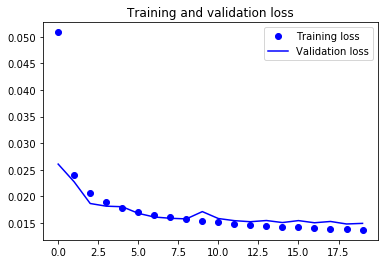

In [43]:
#Training process stores a log file so we can plot the loss vs epochs
#Can be seen how some overfitting happens at the very beggining, then as the process continues
#the training and validation losses remain closer so the model generalizes well

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [45]:
#Once the model is trained, we can feed it with test images and verify its predictions

pred = autoencoder.predict(x_test_noisy)

Test Images


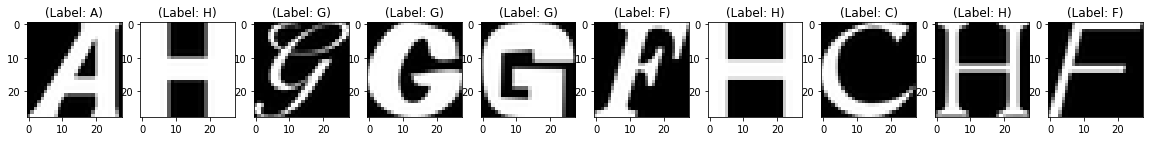

Test Images with Noise


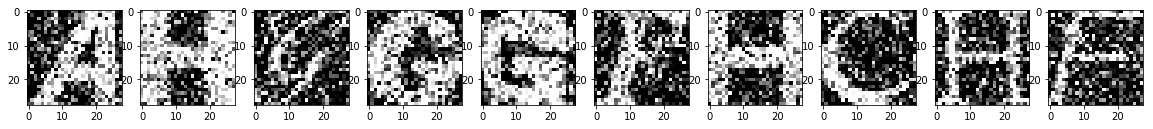

Reconstruction of Noisy Test Images


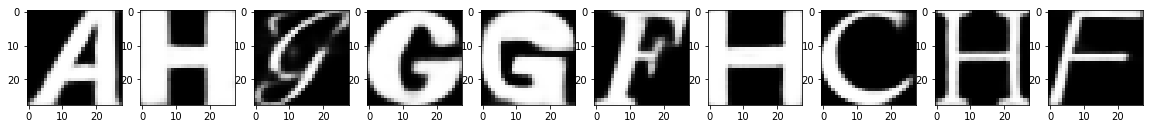

In [46]:
#Plot some of the original images with their noisy and reconstructed versions
#Can be seen that complex shapes as cursive letters represent a hardedr task for the autoencoder

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    

plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

#  Test using handwritten digits

In [47]:
#Import, load, reshape and normalize the new dataset

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_x = x_train.reshape(60000, 784) / 255
val_x = x_test.reshape(10000, 784) / 255

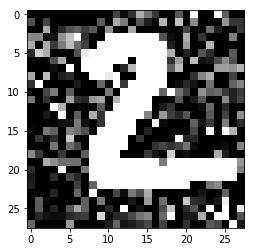

In [48]:
#Add some noise the same way we did before

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

plt.imshow(x_test_noisy[1].reshape(28, 28), cmap='gray')

In [49]:
#Dimensions of the input vector needs to match the input layer
#Since we are changing only the input data, we don't need to re-train the network

x_test_noisy = x_test_noisy.reshape(-1, 28,28, 1)
pred_dig = autoencoder.predict(x_test_noisy)

Test Images with Noise


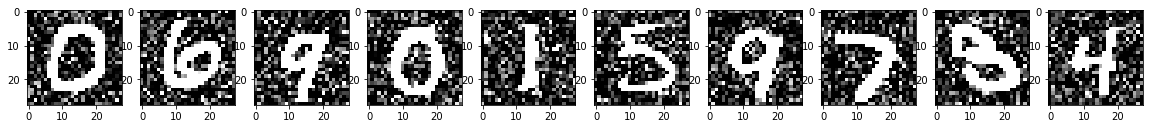

Reconstruction of Noisy Test Images


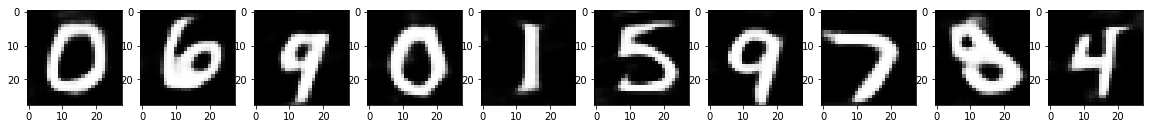

In [50]:
#Plot some of the inputs and the images reconstructed

plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred_dig[i, ..., 0], cmap='gray')  
plt.show()